# Feature importance

In [25]:
import sklearn
sklearn.set_config(display="diagram")

In this notebook, we will discuss the feature importance provided by scikit-learn and the potential caveat. Tree-based model provide a fitted attribute named `feature_importances_` based on the mean decrease in impurity (MDI)

We will show that you need to be careful whenever using it and provide an alternative.

We will illustrate our example on the Titanic dataset.

In [26]:
from sklearn.datasets import fetch_openml

X, y = fetch_openml("titanic", version=1, as_frame=True, return_X_y=True)
X.head()

,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1.0,"Allen, Miss. Elisabeth Walton",female,29.0000,0.0,0.0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1.0,"Allison, Master. Hudson Trevor",male,0.9167,1.0,2.0,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1.0,"Allison, Miss. Helen Loraine",female,2.0000,1.0,2.0,113781,151.5500,C22 C26,S,None,NaN,"Montreal, PQ / Chesterville, ON"
3,1.0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1.0,2.0,113781,151.5500,C22 C26,S,None,135.0,"Montreal, PQ / Chesterville, ON"
4,1.0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1.0,2.0,113781,151.5500,C22 C26,S,None,NaN,"Montreal, PQ / Chesterville, ON"


To better illustrate the limitation of the MDI approach, we will add some random features.

In [27]:
import numpy as np

rng = np.random.RandomState(seed=42)
X['random_cat'] = rng.randint(3, size=X.shape[0])
X['random_num'] = rng.randn(X.shape[0])

In [28]:
categorical_columns = ['pclass', 'sex', 'embarked', 'random_cat']
numerical_columns = ['age', 'sibsp', 'parch', 'fare', 'random_num']

X = X[categorical_columns + numerical_columns]

To simplify some explanation, we will make a single train-test split.

In [29]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, random_state=42
)

## Our predictive pipeline

Since we will use a `RandomForestClassifier`, we will encode our categorical columns using an `OrdinalEncoder`. Let's first create our preprocessor.

In [30]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer


categorical_encoder = OneHotEncoder(handle_unknown='ignore')
numerical_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='mean'))
])

preprocessing = ColumnTransformer(
    [('cat', categorical_encoder, categorical_columns),
     ('num', numerical_pipe, numerical_columns)])
preprocessing

ColumnTransformer(transformers=[('cat', OneHotEncoder(handle_unknown='ignore'),
                                 ['pclass', 'sex', 'embarked', 'random_cat']),
                                ('num',
                                 Pipeline(steps=[('imputer', SimpleImputer())]),
                                 ['age', 'sibsp', 'parch', 'fare',
                                  'random_num'])])

Finally, we can create our full model and train it.

In [31]:
model = Pipeline([
    ('preprocess', preprocessing),
    ('classifier', RandomForestClassifier(random_state=42))
])
model.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['pclass', 'sex', 'embarked',
                                                   'random_cat']),
                                                 ('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer())]),
                                                  ['age', 'sibsp', 'parch',
                                                   'fare', 'random_num'])])),
                ('classifier', RandomForestClassifier(random_state=42))])

## Accuracy of the Model
Prior to inspecting the feature importances, it is important to check that
the model predictive performance is high enough. Indeed there would be little
interest of inspecting the important features of a non-predictive model.

Here one can observe that the train accuracy is very high (the forest model
has enough capacity to completely memorize the training set) but it can still
generalize well enough to the test set thanks to the built-in bagging of
random forests.

It might be possible to trade some accuracy on the training set for a
slightly better accuracy on the test set by limiting the capacity of the
trees (for instance by setting ``min_samples_leaf=5`` or
``min_samples_leaf=10``) so as to limit overfitting while not introducing too
much underfitting.

However let's keep our high capacity random forest model for now so as to
illustrate some pitfalls with feature importance on variables with many
unique values.



In [32]:
print(f"RF train accuracy: {model.score(X_train, y_train):.3f}")
print(f"RF test accuracy: {model.score(X_test, y_test):.3f}")

RF train accuracy: 1.000
RF test accuracy: 0.817


## Tree's Feature Importance from Mean Decrease in Impurity (MDI)
The impurity-based feature importance ranks the numerical features to be the
most important features. As a result, the non-predictive ``random_num``
variable is ranked the most important!

This problem stems from two limitations of impurity-based feature
importances:

- impurity-based importances are biased towards high cardinality features;
- impurity-based importances are computed on training set statistics and
  therefore do not reflect the ability of feature to be useful to make
  predictions that generalize to the test set (when the model has enough
  capacity).



In [33]:
import seaborn as sns
sns.set_context("poster")

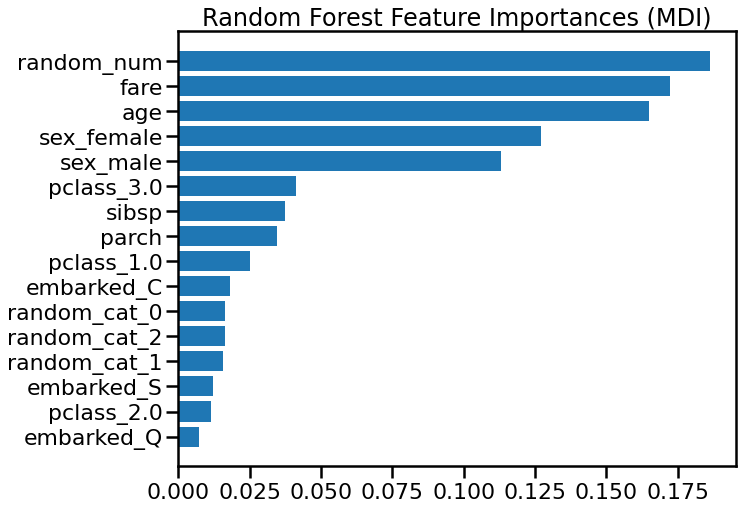

In [42]:
ohe = (model.named_steps['preprocess']
            .named_transformers_['cat'])
feature_names = ohe.get_feature_names_out(categorical_columns)
feature_names = np.r_[feature_names, numerical_columns]

tree_feature_importances = (
    model.named_steps['classifier'].feature_importances_)
sorted_idx = tree_feature_importances.argsort()

y_ticks = np.arange(0, len(feature_names))
fig, ax = plt.subplots(figsize=(10, 8))
ax.barh(y_ticks, tree_feature_importances[sorted_idx])
ax.set_yticks(y_ticks)
ax.set_yticklabels(feature_names[sorted_idx])
_ = ax.set_title("Random Forest Feature Importances (MDI)")

As an alternative, the permutation importances of ``model`` are computed on a
held out test set. This shows that the low cardinality categorical feature,
``sex`` is the most important feature.

Also note that both random features have very low importances (close to 0) as
expected.



In [49]:
result = permutation_importance(
    model, X_test, y_test, n_repeats=10,
    random_state=42, n_jobs=2
)
sorted_idx = result.importances_mean.argsort()

In [53]:
import pandas as pd

importances = pd.DataFrame(
    result.importances[sorted_idx].T,
    columns=X_test.columns[sorted_idx],
)

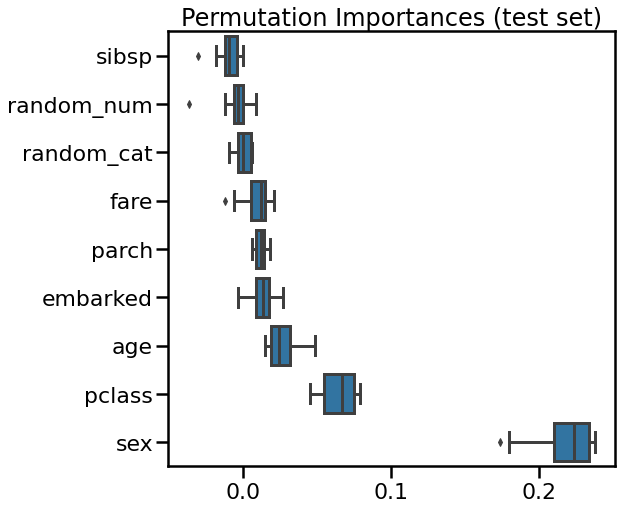

In [59]:
_, ax = plt.subplots(figsize=(8, 8))
sns.boxplot(data=importances, orient="h", color="tab:blue", ax=ax)
_ = ax.set_title("Permutation Importances (test set)")

It is also possible to compute the permutation importances on the training
set. This reveals that ``random_num`` gets a significantly higher importance
ranking than when computed on the test set. The difference between those two
plots is a confirmation that the RF model has enough capacity to use that
random numerical feature to overfit. You can further confirm this by
re-running this example with constrained random forest with `min_samples_leaf=10`.



In [60]:
result = permutation_importance(
    model, X_train, y_train, n_repeats=10,
    random_state=42, n_jobs=2
)
sorted_idx = result.importances_mean.argsort()

In [61]:
import pandas as pd

importances = pd.DataFrame(
    result.importances[sorted_idx].T,
    columns=X_test.columns[sorted_idx],
)

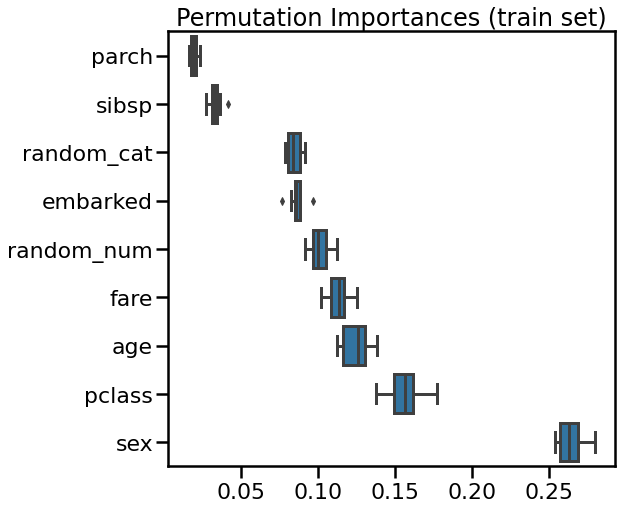

In [62]:
_, ax = plt.subplots(figsize=(8, 8))
sns.boxplot(data=importances, orient="h", color="tab:blue", ax=ax)
_ = ax.set_title("Permutation Importances (train set)")